In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D,MaxPool2D,Dropout,Flatten,Dense,BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [5]:
infected = os.listdir('/kaggle/input/cell-images-for-detecting-malaria/cell_images/Parasitized/')
uninfected = os.listdir('/kaggle/input/cell-images-for-detecting-malaria/cell_images/cell_images/Uninfected/')

In [6]:
print(f"Dataset size: {len(infected) + len(uninfected)} images")

Dataset size: 27560 images


In [7]:
rnd_img1 = cv2.imread("/kaggle/input/cell-images-for-detecting-malaria/cell_images/Parasitized/C100P61ThinF_IMG_20150918_144104_cell_162.png")
rnd_img2 = cv2.imread("/kaggle/input/cell-images-for-detecting-malaria/cell_images/Parasitized/C100P61ThinF_IMG_20150918_144104_cell_163.png")
rnd_img1.shape, rnd_img2.shape

((148, 142, 3), (208, 148, 3))

In [26]:
df = pd.DataFrame(pd.Series(labels))
df['labels'] = df[0]

In [8]:
data = []
labels = []

for i in infected:
    try:

        image = cv2.imread("/kaggle/input/cell-images-for-detecting-malaria/cell_images/Parasitized/"+i)
        image_array = Image.fromarray(image , 'RGB')
        resize_img = image_array.resize((50 , 50)) # size differs in each image so we need to convert all images to 50x50
        rotated45 = resize_img.rotate(45)
        rotated75 = resize_img.rotate(75)
        blur = cv2.blur(np.array(resize_img) ,(10,10))
        data.append(np.array(resize_img))
        data.append(np.array(rotated45))
        data.append(np.array(rotated75))
        data.append(np.array(blur))
        labels.append(1)
        labels.append(1)
        labels.append(1)
        labels.append(1)

    except AttributeError:
        print('')

for u in uninfected:
    try:

        image = cv2.imread("/kaggle/input/cell-images-for-detecting-malaria/cell_images/Uninfected/"+u)
        image_array = Image.fromarray(image , 'RGB')
        resize_img = image_array.resize((50 , 50))
        rotated45 = resize_img.rotate(45)
        rotated75 = resize_img.rotate(75)
        data.append(np.array(resize_img))
        data.append(np.array(rotated45))
        data.append(np.array(rotated75))
        labels.append(0)
        labels.append(0)
        labels.append(0)

    except AttributeError:
        print('')

In [4]:
data[0].shape

(50, 50, 3)

In [5]:
cells = np.array(data)
labels = np.array(labels)

In [6]:
print('Cells : {} | labels : {}'.format(cells.shape , labels.shape))

Cells : (96453, 50, 50, 3) | labels : (96453,)


In [39]:
pd.Series(labels).value_counts(normalize=True) # Baseline = 57%

1    0.571429
0    0.428571
Name: proportion, dtype: float64

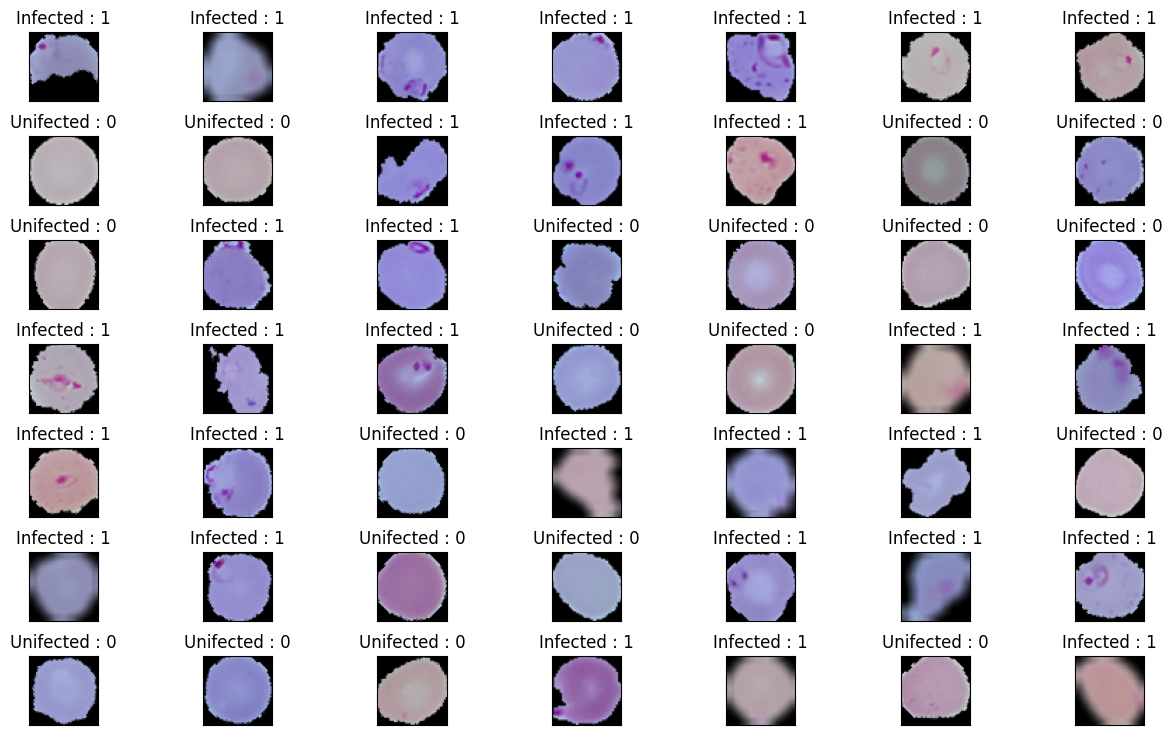

In [7]:
plt.figure(1 , figsize = (15 , 9))
n = 0
for i in range(49):
    n += 1
    r = np.random.randint(0 , cells.shape[0] , 1)
    plt.subplot(7 , 7 , n)
    plt.subplots_adjust(hspace = 0.5 , wspace = 0.5)
    plt.imshow(cells[r[0]])
    plt.title('{} : {}'.format('Infected' if labels[r[0]] == 1 else 'Unifected' ,
                               labels[r[0]]))
    plt.xticks([]) , plt.yticks([])

plt.show()

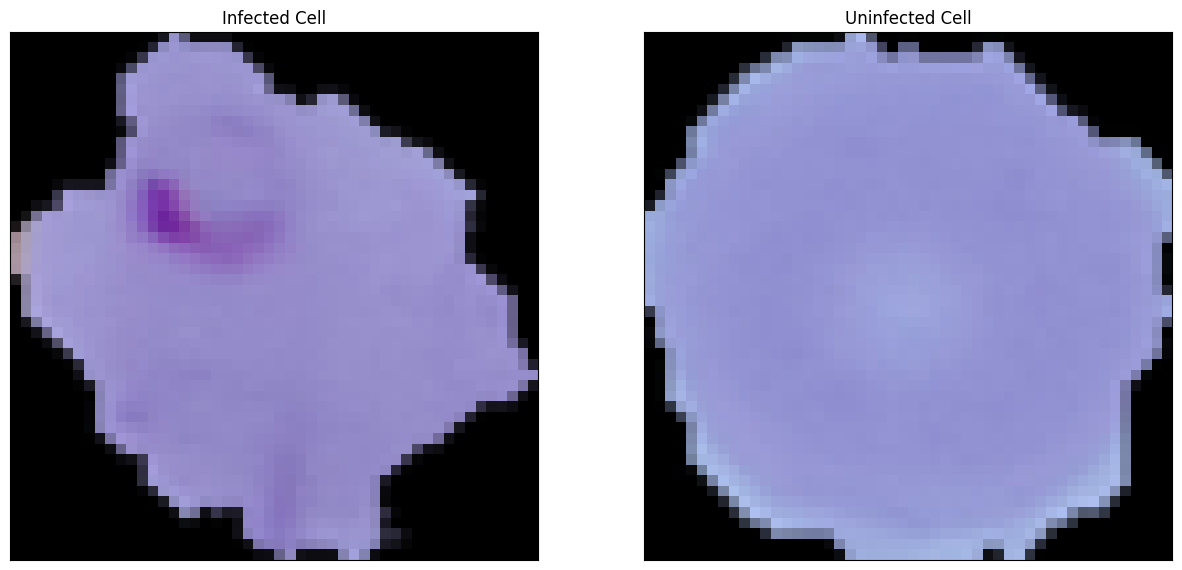

In [8]:
plt.figure(1, figsize = (15 , 7))
plt.subplot(1 , 2 , 1)
plt.imshow(cells[0])
plt.title('Infected Cell')
plt.xticks([]) , plt.yticks([])

plt.subplot(1 , 2 , 2)
plt.imshow(cells[60000])
plt.title('Uninfected Cell')
plt.xticks([]) , plt.yticks([])

plt.show()

In [9]:
n = np.arange(cells.shape[0])
np.random.shuffle(n)
cells = cells[n]
labels = labels[n]

In [10]:
cells = cells.astype(np.float32)
labels = labels.astype(np.int32)
cells = cells/255

In [11]:
X_train , X_test , y_train , y_test = train_test_split(cells , labels ,
                                            test_size = 0.2 ,
                                            random_state = 42)

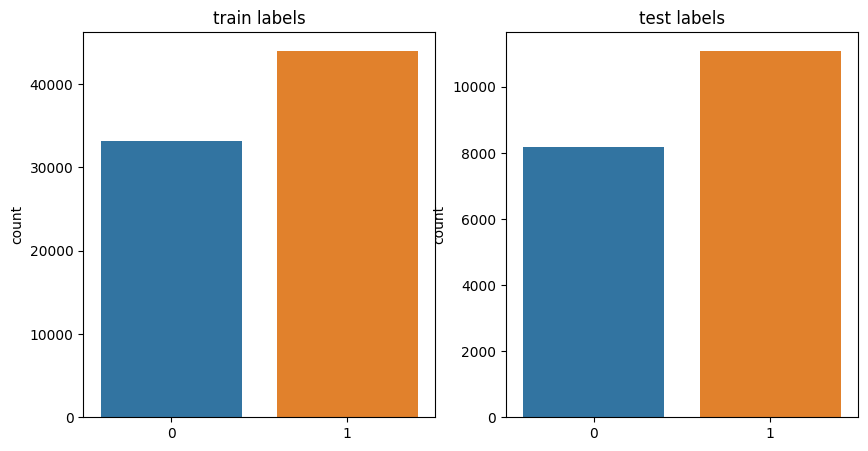

In [12]:
plt.figure(1 , figsize = (10 ,5))
n = 0
for z , j in zip([y_train , y_test] , ['train labels','test labels']):
    n += 1
    plt.subplot(1 , 2  , n)
    sns.countplot(x = z )
    plt.title(j)
plt.show()

In [13]:
print(f'train data shape {X_train.shape}, test data shape {X_test.shape}')

train data shape (77162, 50, 50, 3), test data shape (19291, 50, 50, 3)


In [15]:
model = Sequential()
model.add(Conv2D(16,(3,3),activation='relu',input_shape=(50,50,3)))
model.add(MaxPool2D(2,2))
model.add(Dropout(0.2))

model.add(Conv2D(32,(3,3),activation='relu'))
model.add(MaxPool2D(2,2))
model.add(Dropout(0.3))

model.add(Conv2D(64,(3,3),activation='relu'))
model.add(MaxPool2D(2,2))
model.add(Dropout(0.3))

model.add(Flatten())
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(1,activation='sigmoid'))

In [16]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_accuracy', patience=3)

history = model.fit(X_train, y_train, epochs =60,
                              validation_data = (X_test, y_test), callbacks=[early_stop])

Epoch 1/60


2023-09-05 21:31:09.981418: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


2412/2412 [==============================] - 31s 8ms/step - loss: 0.2832 - accuracy: 0.8790 - val_loss: 0.1475 - val_accuracy: 0.9501
Epoch 2/60
2412/2412 [==============================] - 18s 7ms/step - loss: 0.1642 - accuracy: 0.9474 - val_loss: 0.1413 - val_accuracy: 0.9529
Epoch 3/60
2412/2412 [==============================] - 19s 8ms/step - loss: 0.1514 - accuracy: 0.9516 - val_loss: 0.1312 - val_accuracy: 0.9560
Epoch 4/60
2412/2412 [==============================] - 18s 8ms/step - loss: 0.1475 - accuracy: 0.9534 - val_loss: 0.1395 - val_accuracy: 0.9523
Epoch 5/60
2412/2412 [==============================] - 18s 7ms/step - loss: 0.1426 - accuracy: 0.9543 - val_loss: 0.1250 - val_accuracy: 0.9571
Epoch 6/60
2412/2412 [==============================] - 19s 8ms/step - loss: 0.1385 - accuracy: 0.9554 - val_loss: 0.1221 - val_accuracy: 0.9586
Epoch 7/60
2412/2412 [==============================] - 18s 7ms/step - loss: 0.1387 - accuracy: 0.9559 - val_loss: 0.1403 - val_accuracy: 0.9

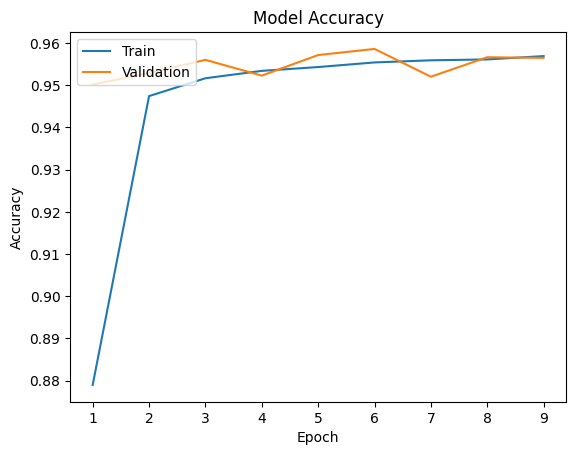

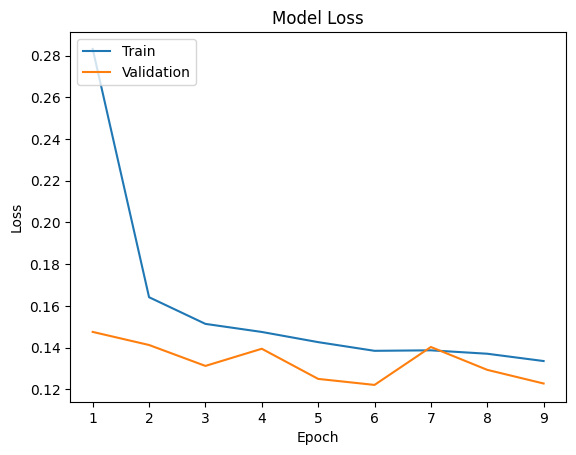

In [17]:
epochRange = range(1,10)
plt.plot(epochRange,history.history['accuracy'])
plt.plot(epochRange,history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train','Validation'],loc='upper left')
plt.show()

plt.plot(epochRange,history.history['loss'])
plt.plot(epochRange,history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train','Validation'],loc='upper left')
plt.show()

In [18]:
model.evaluate(X_test, y_test) # Exceeds baseline (57%)

603/603 [==============================] - 2s 3ms/step - loss: 0.1228 - accuracy: 0.9565


[0.12281126528978348, 0.9564563632011414]

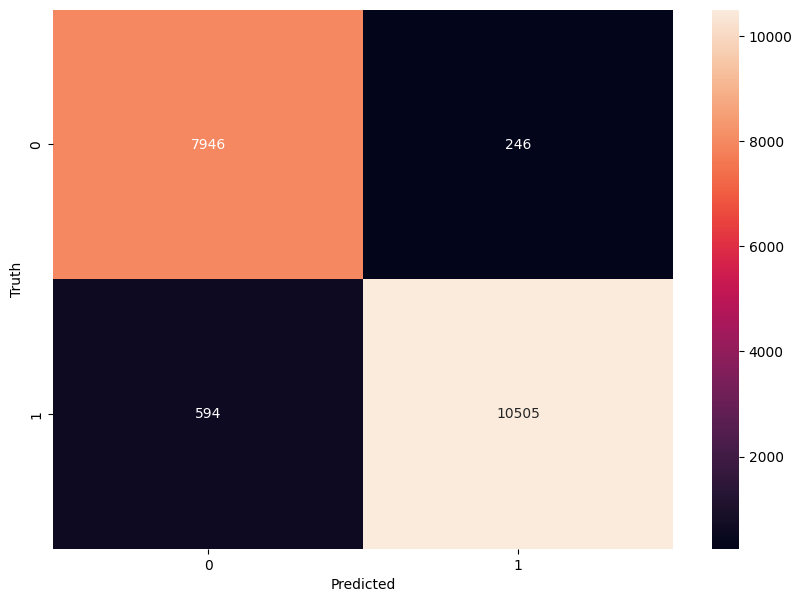

In [21]:
y_pred = model.predict(X_test, verbose=False)
y_pred_labels = [int(i>=0.5) for i in y_pred]S
cm = tf.math.confusion_matrix(labels=y_test, predictions=y_pred_labels)

plt.figure(figsize = (10, 7))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth');

In [26]:
print(classification_report(y_test, y_pred_labels, labels=[0, 1], target_names=["Uninfected", "Infected"]))

              precision    recall  f1-score   support

  Uninfected       0.93      0.97      0.95      8192
    Infected       0.98      0.95      0.96     11099

    accuracy                           0.96     19291
   macro avg       0.95      0.96      0.96     19291
weighted avg       0.96      0.96      0.96     19291

